<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook 6</p></tp>
            <tp><p style="font-size:150%;text-align:center">Búsqueda informada</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Objetivo <a class="anchor" id="inicio"></a>

El objetivo principal de este notebook es el de desarrollar los algoritmos que usan información propia del problema para hacer una búsqueda más eficiente en el espacio de estados. A esta familia de algoritmos se le conoce como *búsqueda informada*. Tenemos tres algoritmos principales, a saber, el algoritmo de Dijkstra (que se pronuncia "daecstra"), el algoritmo avaro y el $A^*$.

Antes de presentar los algoritmos haremos un pequeño desvío por la comparación empírica de algoritmos mediante el tiempo en CPU. También veremos una implementación de listas prioritarias.

[Ir al ejercicio 1](#ej1)

## Dependencias

Al iniciar el notebook o reiniciar el kerner se pueden cargar todas las dependencias de este notebook corriendo las siguientes celdas. Este también es el lugar para instalar las dependencias que podrían hacer falta.

**De Python:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from types import MethodType
import warnings
warnings.filterwarnings('ignore')

**Del notebook:**

In [2]:
from busqueda import *
from tiempos import compara_funciones
from testSuits import test_suit_heuristicas_rompecabezas
from ambientes import OchoReinas, ViajeRumania, Laberinto, Rompecabezas

## Secciones

Desarrollaremos la explicación de la siguiente manera:

* [Comparación de tiempos](#tiempos).
* [Listas prioritarias](#listasp).
* [Problema del viaje a Rumania](#rumania).
* [Algoritmo de Dijkstra](#dijkstra).
* [Búsqueda avara](#avara).
* [Problema del 8 puzzle](#8puzzle).
* [Heurísticas para el 8 puzzle](#heuristicas).
* [Comparación de las heurísticas](#compara).
* [Algoritmo A*](#a_star).

## Comparación empírica de tiempos <a class="anchor" id="tiempos"></a>

([Volver al inicio](#inicio))

La eficiencia de los algoritmos es un tema central en las ciencias de la computación. Ella se estudia usalmente de manera teórica, respecto al tiempo y memoria que consume un algoritmo al correr en un modelo de computación respecto a varios tipos de entradas. En este curso usaremos un enfoque alternativo, aunque también bastante común, a saber, usaremos el tiempo en CPU para evaluar la eficiencia de los algoritmos. Este enfoque no reemplaza al teórico y es sólo una aproximación al mismo. 

Debemos tener presente que el computador es una pieza de hardware cuyos tiempos de funcionamiento dependen de muchas cosas (nivel de energía, estado del hardware, etc.). Además, un computador realiza muchas tareas al mismo tiempo. En consecuencia, medir los tiempos del computador para evaluar una función requiere tratar de cancelar todo este ruido alrededor. Una manera de hacerlo es obtener varias mediciones del mismo proceso. 

Vamos a hacer un ejemplo con el problema de las ocho reinas. Inicializamos un tablero ya con tres reinas (de lo contrario, los algoritmos tomarán mucho tiempo en terminar).

In [3]:
prob = OchoReinas()
s = prob.estado_inicial
s = prob.transicion(s,(0,4))
s = prob.transicion(s,(1,6))
s = prob.transicion(s,(2,1))
prob.estado_inicial = s # Modificamos el estado inicial por defecto del problema

Ahora encontramos los tiempos en CPU usando la función `compara_funciones` que se encuentra en el módulo `tiempos.py`.

In [4]:
funs = [anchura,
        profundidad,
        lambda problema: backtracking(problema, Nodo(problema.estado_inicial, None, None, 0, problema.codigo(problema.estado_inicial)))]
args = [[prob],[prob],[prob]]
nombres = ['Primero en anchura', 
           'Primero en profundidad', 
           'Backtracking']
data = compara_funciones(lista_funs=funs, 
                         lista_args=args, 
                         lista_nombres=nombres, 
                         num_it=10)

Los resultados los hemos guardado en el dataframe `data`. Podemos correr unas estadísticas descriptivas:

In [5]:
data.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})

tiempo_CPU          
                             mean       std
Función                                    
Backtracking             0.009306  0.002378
Primero en anchura       0.660961  0.029803
Primero en profundidad   0.012006  0.000715

Observe que el más lento es primero en anchura y el más rápido el backtracking. Esta información se puede presentar visualmente mediante unos diagramas de caja y bigotes:

<Axes: xlabel='Función', ylabel='tiempo_CPU'>

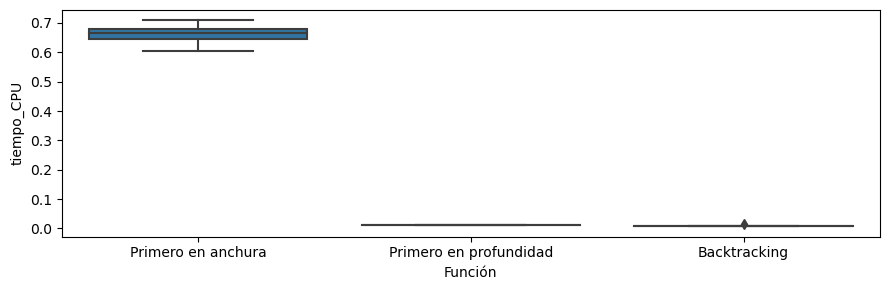

In [6]:
fig, ax = plt.subplots(1,1, figsize=(3*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='tiempo_CPU')

Como los algoritmos primero en profundidad y backtracking tienen desempeños muy similares, en comparación con el primero en anchura, vale la pena hacer una visualización solo de los dos primeros:

<Axes: xlabel='Función', ylabel='tiempo_CPU'>

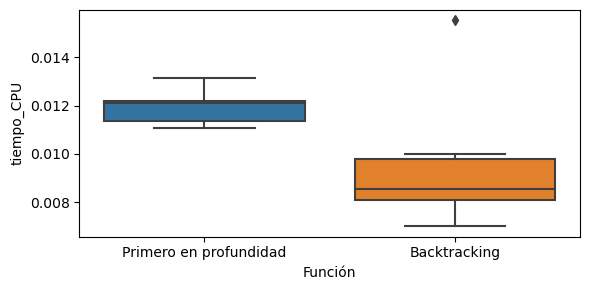

In [7]:
ganadores = ['Primero en profundidad', 'Backtracking']
data_2 = data[data.Función.isin(ganadores)]
fig, ax = plt.subplots(1,1, figsize=(6,3), tight_layout=True)
sns.boxplot(data=data_2, x='Función', y='tiempo_CPU')

## Listas prioritarias <a class="anchor" id="listasp"></a>

([Volver al inicio](#inicio))

En una lista prioritaria los elementos tienen una prioridad de acuerdo al valor que reciben por una función de evaluación $f$. Para este tipo de listas, la acción POP remueve y retorna el elemento prioritario, que es aquel con valor mínimo de $f$. Cuando dos elementos tienen la misma prioridad, el primer elemento en ser incluido es el primero en salir.

Existen librerías que proporcionan objetos que implementan listas prioritarias, como <a href="https://pypi.org/project/HeapDict/">heapdict</a>. Aquí utilizaremos el siguiente objeto `ListaPrioritaria` para implementar las listas prioritarias:

In [8]:
import numpy as np
from collections import namedtuple

Tupla = namedtuple('Tupla', ['elemento', 'valor'])
class ListaPrioritaria():
    
    def __init__(self):
        self.pila = []
        
    def __len__(self):
        return len(self.pila)

    def push(self, elemento, valor):
        tupla = Tupla(elemento, valor)
        self.pila.append(tupla)
        self.pila.sort(key=lambda x: x[1])
            
    def pop(self):
        return self.pila.pop(0)[0]
    
    def is_empty(self):
        return len(self.pila) == 0
    
    def __len__(self):
        return len(self.pila)

    def __str__(self):
        cadena = '['
        inicial = True
        for elemento, valor in self.pila:
            if inicial:
                cadena += '(' + str(elemento) + ',' + str(valor) + ')'
                inicial = False
            else:
                cadena += ', (' + str(elemento) + ',' + str(valor) + ')'
        return cadena + ']'

La idea detrás de este objeto es mantener una lista de parejas (elemento, valor), que se ordena por el valor, es decir, el segundo elemento de la pareja. De esta manera, al llamar el método `pop`, se devuelve el primer argumento de la pareja de menor valor.

Vamos a incluir algunos elementos en nuestra lista. Observe que incluimos las prioridades manualmente, sin recurrir a una función $f$:

In [9]:
lista = ListaPrioritaria()
lista.push('g', 2)
lista.push('e', 3)
lista.push('k', 1)
lista.push('s', 2)
print("La lista prioritaria:", lista)

La lista prioritaria: [(k,1), (g,2), (s,2), (e,3)]


El método `pop` devuelve el elemento prioritario:

In [10]:
n = lista.pop()
n

'k'

Observe que tanto 'g' como 's' tienen la misma prioridad. No obstante, 'g' fue el primero en ser incluido en `lista` y, por lo tanto, es el primero en salir:

In [11]:
print("La lista prioritaria:", lista)
print("Al hacer pop con dos elementos con el mismo valor se obtiene:", lista.pop())

La lista prioritaria: [(g,2), (s,2), (e,3)]
Al hacer pop con dos elementos con el mismo valor se obtiene: g


Para determinar si la lista prioritaria está vacía, usamos el método `is_empty`.

In [12]:
print("La lista prioritaria:", lista)
print("Longitud:", len(lista))
print("Lista vacía?", lista.is_empty())

La lista prioritaria: [(s,2), (e,3)]
Longitud: 2
Lista vacía? False


## El problema del viaje a Rumania <a class="anchor" id="rumania"></a>

([Volver al inicio](#inicio))

Imagine que usted viaja a Rumania y que desconoce por completo el país, pero tiene a mano un mapa de los caminos, que le indica las longitudes en kilómetros, como el siguiente:

<img src="./imagenes/Rumania.png" width="500px"/>

El problema consiste en, dada una ciudad de salida y una ciudad de llegada, encontrar el camino más corto.

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

Complete la definición formal del problema del viaje a Rumania:    

* **Estado inicial**: 

* **Posibles acciones**: 

* **Función de transiciones**: 

* **Prueba de satisfacción del objetivo**: 

* **Función de costo**: 

---

Supongamos que nuestro problema es ir desde Arad hasta Bucharest. Entonces creamos el problema así:

In [13]:
viaje = ViajeRumania('Arad', 'Bucharest')

Observe que el problema tiene un atributo de rutas, que podemos visualizar así:

In [14]:
viaje.rutas

{'Oradea': {'Zerind': 71, 'Sibiu': 151},
 'Zerind': {'Arad': 75, 'Oradea': 71},
 'Arad': {'Timisoara': 118, 'Sibiu': 140, 'Zerind': 71},
 'Timisoara': {'Lugoj': 111, 'Arad': 118},
 'Lugoj': {'Mehadia': 70, 'Timisoara': 111},
 'Mehadia': {'Drobeta': 75, 'Lugoj': 70},
 'Drobeta': {'Craiova': 120, 'Mehadia': 75},
 'Sibiu': {'Fagaras': 99, 'Rimnicu Vilcea': 80, 'Arad': 140, 'Oradea': 151},
 'Rimnicu Vilcea': {'Craiova': 146, 'Pitesti': 97, 'Sibiu': 80},
 'Craiova': {'Pitesti': 138, 'Drobeta': 120, 'Rimnicu Vilcea': 146},
 'Fagaras': {'Bucharest': 211, 'Sibiu': 99},
 'Pitesti': {'Bucharest': 101, 'Craiova': 138, 'Rimnicu Vilcea': 97},
 'Bucharest': {'Giurgiu': 90, 'Urziceni': 85, 'Fagaras': 211, 'Pitesti': 101},
 'Giurgiu': {'Bucharest': 90},
 'Urziceni': {'Vaslui': 142, 'Hirsova': 98, 'Bucharest': 85},
 'Vaslui': {'Iasi': 92, 'Urziceni': 142},
 'Iasi': {'Neamt': 87, 'Vaslui': 92},
 'Neamt': {'Iasi': 87},
 'Hirsova': {'Eforie': 86, 'Urziceni': 98},
 'Eforie': {'Hirsova': 86}}

Este atributo se utiliza tanto para encontrar las acciones aplicables como para determinar los costos de ir de una ciudad a una ciudad vecina.

## Algoritmo de Dijkstra <a class="anchor" id="dijkstra"></a>

([Volver al inicio](#inicio))

Al realizar una búsqueda en un espacio de estados usando una función de costo, creamos una frontera mediante una lista prioritaria. En esta lista, el valor de cada nodo es su costo camino. Observe que estos costos siempre crecerán a medida que aumentamos la longitud del camino. En este algoritmo primero expandimos el nodo de menor costo.

El siguiente es el pseudocódigo del algoritmo:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> dijkstra(<font style="font-style: italic;">problema</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor 0<br>
&nbsp;&nbsp; <font style="font-style: italic;">explorados</font> &#8592; diccionario con 1 item con key <font style="font-style: italic;">cod</font> y valor 0 <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">hijo</font>.codigo <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">c</font> &#8592; <font style="font-style: italic;">hijo</font>.costo_camino <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">cod</font> <font style="font-weight: bold;" color = "red">not in</font> <font style="font-style: italic;">explorados</font>.keys <font style="font-weight: bold;" color = "red">or</font> <font style="font-style: italic;">c</font> &#60; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD((<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">c</font>), <font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] &#8592; <font style="font-style: italic;">c</font> <br>
    &nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>

El algoritmo toma el estado inicial del problema, le calcula su código y, luego, crea el nodo raiz. A continuación, inicia la lista `frontera` como una lista prioritaria. También inicializa el diccionario `explorados`, mediante el cual se van a relacionar los nodos con su `costo_camino`. Este diccionario permitirá tanto llevar la cuenta de cuáles estados hemos visitado, como de asociar el costo en que se incurre para llegar hasta un estado particular partiendo desde el estado inicial.

<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

Implemente el algoritmo de Dijkstra de acuerdo al anterior pseudocódigo. Verifique que la solución al problema del viaje a Rumania sea:

```
La solución mediante el algoritmo de Dijkstra es:
['Arad', 'Sibiu', 'Rimnicu Vilcea', 'Pitesti', 'Bucharest']
El costo de la solución es: 418
```

In [15]:
def dijkstra(problema):
    pass
    # AQUÍ SU CÓDIGO
    
    # HASTA AQUÍ SU CÓDIGO

In [ ]:
viaje = ViajeRumania('Arad', 'Bucharest')
solucion_dijkstra = dijkstra(viaje)
camino_anchura = [viaje.estado_inicial] + solucion(solucion_dijkstra)
print('La solución mediante el algoritmo de Dijkstra es:')
print(camino_anchura)
print('El costo de la solución es:', solucion_dijkstra.costo_camino)


---

**Cuando el orden de los factores sí altera el producto**

Veremos ahora un ejemplo que nos permite justificar por qué la verificación de la prueba de satisfacción de objetivo se realiza al explorar la frontera, no al expandir un nodo. Observe que en el notebook 2 realizábamos esta verificación al expandir un nodo. Si encontrábamos una solución, estaba bien y concluíamos la búsqueda. En el algoritmo `best_first_search` somos un poco más cuidadosos y no verificamos sino hasta expandir la frontera de acuerdo a la lista prioritaria. La razón de esto podemos verla con un ejemplo.

Consideremos el problema de ir desde Sibiu a Bucharest.

<img src="./imagenes/Sibiu2Bucharest.png" width="280px"/>

Los sucesores de Sibiu son Rimnicu Vilcea y Fagaras, con un coste de 80 y 99, respectivamente. El nodo de menor costo, Rimnicu Vilcea, se amplía a continuación, añadiendo Pitesti con un costo de 80+97=177. El nodo de menor costo es ahora Fagaras, por lo que se amplía, añadiendo Bucarest con un costo de 99 + 211 = 310. Bucarest es el objetivo, pero el algoritmo sólo comprueba los objetivos cuando expande un nodo, no cuando genera un nodo, por lo que aún no ha detectado que éste es un camino hacia el objetivo.

El algoritmo continúa, eligiendo Pitesti para la siguiente expansión y añadiendo un segundo camino a Bucarest con un costo de 80 + 97 + 101 = 278. Tiene un costo menor, por lo que sustituye a la ruta anterior alcanzada y se añade a la frontera. Resulta que este nodo tiene ahora el costo más bajo, por lo que se considera el siguiente, se comprueba que es una meta y se devuelve. Nótese que si hubiéramos comprobado la existencia de un objetivo al generar un nodo en lugar de al ampliar el nodo de menor costo, habríamos devuelto un camino de mayor costo (el que pasa por Fagaras).



## Búsqueda avara <a class="anchor" id="avara"></a>

([Volver al inicio](#inicio))

Hasta el momento hemos usado una función de costo para ordenar los nodos en la frontera. Esto nos permite explorar primero el nodo cuyo `costo_camino` sea óptimo hasta el momento. No obstante, también podemos ordenar los nodos usando un criterio distinto, llamado una *función heurística*.

La idea de una heurística es usar información del problema específico que se desea resolver, de tal manera que, para cada estado $s$, se pueda obtener un *costo estimado* (o una *distancia*) para llegar desde $s$ a un estado objetivo dado.

Ilustremos este concepto mediante el ambiente del viaje a Rumania. Observe que cada ciudad tiene una coordenada $(x,y)$. Una estimación del costo de llegar al objetivo desde el estado $(x,y)$ puede ser la distancia euclidiana entre este y el objetivo.

<img src="./imagenes/Rumania1.png" width="auto"/>

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

Implemente la función de distancia en el viaje a Rumania. Observe que cada ciudad tiene una coordenada:

In [ ]:
viaje = ViajeRumania('Arad', 'Bucharest')
viaje.coordenadas

In [ ]:
def distancia(self, ciudad:str) -> float:
    '''
    Devuelve la distancia desde la ciudad hasta la ciudad objetivo
    usando las coordenadas de cada una. Se implementa como un
    método de la clase ViajeRumania.
    Input:
        - ciudad, que es el nombre de una ciudad
    '''
    pass
    # AQUÍ SU CÓDIGO
    
    # HASTA AQUÍ SU CÓDIGO

# Incluimos el método en la clase
setattr(ViajeRumania, 'heuristica', distancia)
# Instanciamos la clase con el problema de ir de Arad a Bucharest
viaje = ViajeRumania('Arad', 'Bucharest')
# Comprobamos la distancia de Arad a Bucharest
viaje.heuristica('Arad')

La respuesta debe ser:

```
493.6361150283255
```

---

El siguiente es el pseudocódigo del algoritmo de búsqueda `avara`:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> avara(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">f</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">problema</font>.heuristica(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor <font style="font-style: italic;">v</font><br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if not</font> is_cycle(<font style="font-style: italic;">hijo</font>) <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">problema</font>.heuristica(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD((<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">v</font>), <font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>




<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Implemente el pseudocódigo de la función `avara` y utilícela para resolver el problema del viaje a Rumania.

La respuesta debe ser:

```
La solución mediante la búsqueda avara es:
['Arad', 'Sibiu', 'Fagaras', 'Bucharest']
El costo de la solución es: 450
```

In [ ]:
def avara(problema):
    pass
    # AQUÍ SU CÓDIGO
    
    # HASTA AQUÍ SU CÓDIGO

In [ ]:
viaje = ViajeRumania('Arad', 'Bucharest')
solucion_avara = avara(viaje)
camino_anchura = [viaje.estado_inicial] + solucion(solucion_avara)
print('La solución mediante la búsqueda avara es:')
print(camino_anchura)
print('El costo de la solución es:', solucion_avara.costo_camino)

---

<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Resuelva el problema del viaje a Rumania mediante los métodos `anchura`, `profundidad`, `backtracking`, `dijkstra` y `avara`. Encuentre:

    1. Tiempos promedio en CPU (use 1000 iteraciones)
    2. Cantidad en kilómetros de la solución.
    
Dibuje una tabla con esta información y comente los resultados.

**Nota: ¡No olvide comentar los resultados!**

---

## El problema del rompecabezas de 8 piezas <a class="anchor" id="8puzzle"></a>

([Volver al inicio](#inicio))

Considere ocho piezas cuadradas, cada una con un número del 1 al 8. Estas piezas se ponen en una caja cuadrada  formando un rompecabezas, de tal manera que queda un espacio del mismo tamaño que las piezas, como en la figura siguiente:

<img src="./imagenes/puzzle1.png" width="350px"/>

Las piezas adyacentes al espacio pueden desplazarse desde su posición hasta ocupar el espacio vacío, de tal manera que es posible cambiar el orden de todas las piezas. El problema consiste en, dada una posición del rompecabezas, encontrar una manera de mover las piezas para lograr otra posición deseada.

La descripción formal del problema es como sigue:

* **Estado inicial**: Un rompezabezas donde las piezas están dispuestas aleatoriamente.

* **Posibles acciones**: Mover una ficha al espacio vacío. En cada configuración hay maximo cuatro fichas que pueden moverse al espacio vacío (cuando este está en el centro). Usualmente solo pueden moverse tres fichas o solo dos, cuando el espacio vacío está en una esquina. 

* **Función de transiciones**: Mover la ficha y obtener el tablero correspondiente.

* **Prueba de satisfacción del objetivo**: El tablero está organizado como sigue:

<img src="./imagenes/objetivo.png" width="350px"/>

* **Función de costo**: Cada acción cuesta 1 punto.

Observe que podemos usar el método `pintar_camino` para visualizar el movimiento correspondiente de las piezas:

In [ ]:
puz = Rompecabezas()
s = np.matrix([[3,1,2], [4,5,8], [0,6,7]])
puz.estado_inicial = s
camino = [((1, 2), (0, 2)), ((2, 2), (1, 2)), ((2, 1), (2, 2)), ((1, 1), (2, 1)), ((0, 1), (1, 1)), ((0, 0), (0, 1))]
puz.pintar_camino(camino)

El problema del rompecabezas es difícil, y usualmente le cuesta un buen tiempo a los métodos de `primero en anchura` y `primero en profundidad` converger en una solución. Si usted es curioso, trate de usar uno de estos métodos para resolver el problema. El resultado que usted debe obtener es una celda que se queda corriendo hasta que se agota la paciencia.

El algoritmo de `dijkstra` es mucho más eficiente que los anteriores, pero aún puede mejorarse, como lo veremos en un momento. Por ahora, el ejercicio es resolver el problema del rompecabezas mediante `dijkstra` y la siguiente función de costo:

In [ ]:
puz = Rompecabezas()
s = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
puz.estado_inicial = s
puz.pintar_estado(puz.estado_inicial)

In [ ]:
%%time
l = dijkstra(puz)
if l is not None:
    camino = solucion(l)
    print("La solución encontrada es: ", camino)
    print("La cantidad de movimientos es: ", len(camino))
else:
    print("No hay solución!")

Observe que en mi computador el algoritmo con costo uniforme tarda cerca de un minuto en converger a una solución.

La solución encontrada la podemos visualizar mediante la siguiente instrucción:

In [ ]:
puz.pintar_camino(camino)

## Heurísticas para el 8 puzzle <a class="anchor" id="heuristicas"></a>

([Volver al inicio](#inicio))

Las heurísticas son reglas de comportamiento que aprovechan el conocimiento específico sobre ciertos problemas. El problema del rompecabezas nos permite explicar esto mejor. Podemos evaluar una especie de distancia entre un estado dado y el estado objetivo mediante el conteo de piezas que no se encuentran en el lugar objetivo. Por ejemplo, considere el siguiente tablero:

In [ ]:
puz = Rompecabezas()
s = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.pintar_estado(s)

En este tablero hay dos piezas que no están en la posición objetivo, a saber, el 3 y el 6. Por lo tanto, la función heurística `piezas_mal_puestas` debe devolver el valor 2.

In [ ]:
puz = Rompecabezas()
s = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.pintar_estado(s)

<a class="anchor" id="ej6"></a>**Ejercicio 6:** 

([Anterior ejercicio](#ej5)) ([Próximo ejercicio](#ej7))

Implemente la función `piezas_mal_puestas`.

**Nota: Para facilidad de la implementación, asuma que el espacio vacío es una pieza.**

La respuesta de la siguiente celda debe ser:
```
Número de piezas mal puestas de s1: 3
Número de piezas mal puestas de s2: 6
Número de piezas mal puestas de s3: 7
```

In [ ]:
def piezas_mal_puestas(self, estado:np.matrix) -> int:
    '''
    Devuelve el número de piezas mal puestas.
    Debe ser implementado como el método de una clase.
    Input:
        - estado, que es una matriz con el estado a evaluar
    Output:
        - entero con el número de piezas mal puestas
    '''
    pass 

    objetivo = self.objetivo

    # COMIENCE AQUÍ SU CÓDIGO

    # AQUÍ TERMINA SU CÓDIGO

# Incluimos el método en la clase
setattr(Rompecabezas, 'heuristica', piezas_mal_puestas)
# Instanciamos la clase con el problema del rompecabezas
puz = Rompecabezas()
# Hacemos las comprobaciones
s1 = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.pintar_estado(s1)
print('Número de piezas mal puestas de s1:', puz.heuristica(s1))
s2 = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
puz.pintar_estado(s2)
print('Número de piezas mal puestas de s2:', puz.heuristica(s2))
s3 = np.matrix([[6, 3, 2], [7, 4, 0], [8, 5, 1]])
print('Número de piezas mal puestas de s3:', puz.heuristica(s3))
puz.pintar_estado(s3)

---

Otra heurística para el problema del rompecabezas es el siguiente. La distancia entre un estado y el objetivo se mide como la suma de las distancias entre cada pieza y su lugar objetivo. Esta última distancia se mide como la distancia del taxista, es decir, la suma de las distancias verticales y horizontales. Por ejemplo, suponga el siguiente estado:

In [ ]:
puz = Rompecabezas()
s = np.matrix([[0,3,2], [4,1,5], [6,7,8]])
puz.pintar_estado(s)


Observe que el 1 está a una casilla de su lugar (una abajo), el cuatro está a una casilla de su lugar (una a la izquierda) y el 3 está a dos casillas de su lugar (una arriba y una a la derecha. El valor de la heurística `manhattan` debe ser 1 + 1 + 2 = 4. 

<a class="anchor" id="ej7"></a>**Ejercicio 7:** 

([Anterior ejercicio](#ej6)) ([Próximo ejercicio](#ej8))

Implemente la función `manhattan`.

**Nota: Para facilidad de la implementación, asuma que el espacio vacío es una pieza.**

La respuesta debe ser:

```
Distancia Manhattan de s1: 4
Distancia Manhattan de s2: 10
Distancia Manhattan de s3: 16
```

In [ ]:
def manhattan(self, estado:np.matrix) -> int:
    '''
    Devuelve la suma de la distancia Manhattan de las piezas 
    respecto a su lugar objetivo en el rompecabezas.
    Debe ser implementado como el método de una clase.
    Input:
        - estado, que es una matriz con el estado a evaluar
    Output:
        - entero con la distancia Manhattan
    '''
    pass

    objetivo = self.objetivo

    # COMIENCE AQUÍ SU CÓDIGO

    # AQUÍ TERMINA SU CÓDIGO

# Incluimos el método en la clase
setattr(Rompecabezas, 'heuristica', manhattan)
# Instanciamos la clase con el problema del rompecabezas
puz = Rompecabezas()
# Hacemos las comprobaciones
s1 = np.matrix([[3,1,2], [6,4,5], [0,7,8]])
puz.pintar_estado(s1)
print('Distancia Manhattan de s1:', puz.heuristica(s1))
s2 = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
puz.pintar_estado(s2)
print('Distancia Manhattan de s2:', puz.heuristica(s2))
s3 = np.matrix([[6, 3, 2], [7, 4, 0], [8, 5, 1]])
print('Distancia Manhattan de s3:', puz.heuristica(s3))
puz.pintar_estado(s3)

---

## Comparando heurísticas <a class="anchor" id="compara"></a>

([Volver al inicio](#inicio))

Al ordenar los nodos explorados mediante una función heurística, lo que se busca es explorar primero aquel nodo que se acerque más al objetivo. Hemos definido dos maneras de estimar esta idea y es hora de compararlas mediante el tiempo de CPU.

<a class="anchor" id="ej8"></a>**Ejercicio 8:** 

([Anterior ejercicio](#ej7)) ([Próximo ejercicio](#ej9))

Compare el tiempo de CPU de las dos heurísticas en el algoritmo de búsqueda `avara`. ¿Cuál tiene mejor tiempo de búsqueda? Comente la solución que se obtiene al correr las siguientes celdas.

In [ ]:
# Definimos los rompecabezas a evaluar
s1 = np.matrix([[3,1,2], [4,5,8], [0,6,7]])
s2 = np.matrix([[4,1,2], [3,0,5], [6,7,8]])
s3 = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
s4 = np.matrix([[1,3,2], [7,4,0], [8,5,6]])
estados = [s1, s3, s4]
# Definimos las heurísticas
heuristicas = [piezas_mal_puestas, manhattan]
nombres = ['piezas_mal_puestas', 'manhattan']
# Creamos el test suite
lista_tests, lista_nombres = test_suit_heuristicas_rompecabezas(estados, heuristicas, nombres)
lista_funs = [avara]*len(lista_tests)

In [ ]:
data = compara_funciones(lista_funs=lista_funs, 
                         lista_args=lista_tests, 
                         lista_nombres=lista_nombres, 
                         num_it=10)
data.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1.5*len(funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='tiempo_CPU')
fig.savefig('box_puzzle.png')

**Respuesta:**

La heurística `manhattan` encuentra una solución de manera más rápida. Esto es así porque ella estima más precisamente qué tan diferente es un estado del objetivo. Por ejemplo, si el 1 esta a tres fichas de distancia, `manhattan` devuelve el valor 3, mientras que si está a dos fichas de distancia, devuelve 2. En ambos casos `piezas_mal_puestas` devuelve el valor 1, sin importar que se necesiten más movimientos en la primera que en la segunda para poner el 1 en su lugar.

---

## Algoritmo A$^*$ <a class="anchor" id="a_star"></a>

([Volver al inicio](#inicio))

Veremos el algoritmo A$^*$, el cual es una forma de Best First Search. En este caso, la evaluación $f$ de los nodos se hace mediante la suma entre su costo_camino $g$ y una heurística $h$ que estima el costo mínimo desde el nodo hasta la solución.

$$f(n) = g(n) + h(n)$$

El siguiente es el pseudocódigo del algoritmo A$^*$:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
<font style="font-weight: bold;" color = "red">function</font> A_star(<font style="font-style: italic;">problema</font>) <font style="font-weight: bold;" color = "red">returns</font> <font style="font-style: italic;">nodo</font> o falla <br>
&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">problema</font>.estado_inicial <br>
&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">problema</font>.heuristica(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">problema</font>.codigo(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; NODO(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp; <font style="font-style: italic;">frontera</font> &#8592; lista prioritaria con 1 item con key <font style="font-style: italic;">nodo</font> y valor v<br>
&nbsp;&nbsp; <font style="font-style: italic;">explorados</font> &#8592; diccionario con 1 item con key <font style="font-style: italic;">cod</font> y valor v <br>
&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">While not</font> VACIA(<font style="font-style: italic;">frontera</font>) <font style="font-weight: bold;" color = "red">do</font> <br> 
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">nodo</font> &#8592; POP(<font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">problema</font>.test_objetivo(<font style="font-style: italic;">nodo</font>.estado) <font style="font-weight: bold;" color = "red">then return</font> <font style="font-style: italic;">nodo</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">for each</font> <font style="font-style: italic;">hijo</font> <font style="font-weight: bold;" color = "red">in</font> EXPAND(<font style="font-style: italic;">problema</font>, <font style="font-style: italic;">nodo</font>) <font style="font-weight: bold;" color = "red">do</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">s</font> &#8592; <font style="font-style: italic;">hijo</font>.estado<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">v</font> &#8592; <font style="font-style: italic;">problema</font>.heuristica(<font style="font-style: italic;">s</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">cod</font> &#8592; <font style="font-style: italic;">hijo</font>.codigo <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">c</font> &#8592; <font style="font-style: italic;">hijo</font>.costo_camino <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">h</font> &#8592; <font style="font-style: italic;">v</font> + <font style="font-style: italic;">c</font><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-weight: bold;" color = "red">if</font> <font style="font-style: italic;">cod</font> <font style="font-weight: bold;" color = "red">not in</font> <font style="font-style: italic;">explorados</font>.keys <font style="font-weight: bold;" color = "red">or</font> <font style="font-style: italic;">h</font> &#60; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] <font style="font-weight: bold;" color = "red">then</font> <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ADD((<font style="font-style: italic;">hijo</font>, <font style="font-style: italic;">h</font>), <font style="font-style: italic;">frontera</font>) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font style="font-style: italic;">explorados</font>[<font style="font-style: italic;">cod</font>] &#8592; <font style="font-style: italic;">h</font> <br>
    &nbsp;&nbsp; <font style="font-weight: bold;" color = "red">return</font> falla <br>
</div>

**$A^*$ con pesos**

Una versión más poderosa del algoritmo $A^*$ es el llamado $A^*$ con pesos, en el cual la función de evaluación incluye una modificación del término heurístico por un factor $W$, de la siguiente manera:

$$f(n) = g(n) + W\times h(n)$$

donde $W > 1$. Esto significa que la función de evaluación da mayor peso al estimado de la función heurística, sin dejar de considerar el costo camino.

<a class="anchor" id="ej9"></a>**Ejercicio 9:** 

([Anterior ejercicio](#ej8))

Implemente el algoritmo $A^*$ con pesos y pruebe a resolver el problema del rompecabezas siguiente.

In [ ]:
def A_star(problema, W=2.5):
    pass
    # AQUÍ SU CÓDIGO
    
    # HASTA AQUÍ SU CÓDIGO

In [ ]:
setattr(Rompecabezas, 'heuristica', manhattan)
puz = Rompecabezas()
s = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
puz.estado_inicial = s
puz.pintar_estado(puz.estado_inicial)

In [ ]:
%%time
l = A_star(puz)
if l is not None:
    camino = solucion(l)
    print("La solución encontrada es: ", camino)
    print("La cantidad de movimientos es: ", len(camino))
else:
    print("No hay solución!")

---

**Comparación entre búsqueda avara y $A^*$**

Vamos a comparar la búsqueda avara y $A^*$, en ambos casos usando la heurística de la distancia Manhattan. También incluimos un peso de $W=2.5$ en la heurística para la versión $A^*$ con pesos.

In [ ]:
# Definimos los rompecabezas a evaluar
s1 = np.matrix([[3,1,2], [4,5,8], [0,6,7]])
s2 = np.matrix([[4,1,2], [3,0,5], [6,7,8]])
s3 = np.matrix([[3,2,1], [5,4,6], [0,7,8]])
s4 = np.matrix([[1,3,2], [7,4,0], [8,5,6]])
estados = [s1, s3, s4]
# Definimos las heurísticas
heuristicas = [manhattan]
nombres = ['manhattan']
# Creamos el test suite
lista_tests, lista_nombres = test_suit_heuristicas_rompecabezas(estados, heuristicas, nombres)
lista_funs = [avara]*len(lista_tests) + [lambda prob: A_star(prob, W=2.5)]*len(lista_tests)
lista_nombres += ['$A^*$']*len(lista_tests)
lista_tests += lista_tests

In [ ]:
data = compara_funciones(lista_funs=lista_funs, 
                         lista_args=lista_tests, 
                         lista_nombres=lista_nombres, 
                         num_it=10)
data.groupby('Función').agg({'tiempo_CPU':['mean', 'std']})

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(1.5*len(lista_funs),3), tight_layout=True)
sns.boxplot(data=data, x='Función', y='tiempo_CPU')
fig.savefig('box_puzzle1.png')

## En este notebook usted aprendió

([Volver al inicio](#inicio))

* Cómo realizar una búsqueda mediante el algoritmo de Dijkstra, la búsqueda avara y el algoritmo $A^*$.
* Implementar y comparar distintas heurísticas para resolver el problema del rompecabezas.
* Comparar los tiempos y la optimalidad de las heurísticas.

---